# SI 618 Final Project
## Busted: Analyzing Job Posting Patterns and Predicting Fraudulent Job
### Jing Cao, School of Information, University of Michigan

In [1]:
MY_UNIQNAME = 'jingcao'

In [2]:
import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats as stats
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import sklearn.ensemble as skens
import sklearn.metrics as skmetric
from sklearn.metrics import accuracy_score
import sklearn.naive_bayes as sknb
from sklearn.model_selection import GridSearchCV
import sklearn.tree as sktree
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='white', color_codes=True, font_scale=1.3)
import sklearn.externals.six as sksix
import IPython.display as ipd
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import os

/Users/JINGCAO/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


In [3]:
# Filter all warnings.
import warnings
warnings.filterwarnings('ignore')

In [4]:
jobs = pd.read_csv('fake_job_postings.csv')

In [5]:
jobs.shape

(17880, 18)

In [6]:
jobs.sample(5)

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
13434,13435,Core Systems Engineer,"US, TX, Austin",Engineering,NaN,MaxPlay™ is a cross-platform digital publishin...,The Core Systems Engineer will work to impleme...,At least 3 years of C++ experienceAt least 1 y...,NaN,0,1,0,Full-time,Mid-Senior level,NaN,Entertainment,Engineering,0
4405,4406,Recruitment Consultant - CONSTRUCTION,NaN,NaN,NaN,Agensi Pekerjaan Gen Y HR Sdn. Bhd. is revolut...,We are revolutionising the Recruitment Agency ...,1) A strong affinity to working with people2) ...,Pre-requisites1) A diploma or bachelors degree...,0,1,1,Full-time,Entry level,Bachelor's Degree,Construction,Consulting,0
7382,7383,Call Center Supervisor,"US, VA, Virginia Beach",NaN,NaN,Tidewater Finance Co. was established in 1992 ...,"Tidewater Finance Company, located in Virginia...",Qualified candidates should possess the follow...,Our company offers a competitive salary plus B...,0,1,0,Full-time,Mid-Senior level,Unspecified,Financial Services,Management,0
3886,3887,Director / Head of Operations,"SG, ,",NaN,40000-100000,If working in a cubical seems like your idea o...,"As the TradeGecko Head of Operations, you will...",Key responsibilities include:Formulate and imp...,NaN,0,1,0,Full-time,Director,NaN,Information Technology and Services,General Business,0
42,43,Jr. Developer,US,NaN,40000-50000,NaN,Entry level Software DeveloperLocation : Atlan...,NaN,NaN,0,0,0,Full-time,Entry level,Bachelor's Degree,Computer Software,Engineering,0


In [7]:
jobs = jobs[['title', 'description', 'benefits', 'telecommuting', 'has_company_logo', 'has_questions', 'fraudulent']]

In [8]:
jobs.isnull().sum()

title                  0
description            1
benefits            7210
telecommuting          0
has_company_logo       0
has_questions          0
fraudulent             0
dtype: int64

In [9]:
jobs.describe()

,telecommuting,has_company_logo,has_questions,fraudulent
count,17880.000000,17880.000000,17880.000000,17880.000000
mean,0.042897,0.795302,0.491723,0.048434
std,0.202631,0.403492,0.499945,0.214688
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000


## Question1: Is there a relationship between fraudulent job and if the job is telecommuting, has logo or has screening questions?

In [10]:
tele_fraud = pd.crosstab(jobs.telecommuting, jobs.fraudulent)
tele_fraud

fraudulent,0,1
telecommuting,,
0,16311,802
1,703,64


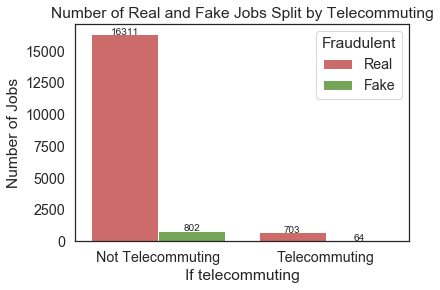

In [11]:
fig, axs = plt.subplots()
# fig.set_size_inches(20, 10)
graph = sns.countplot(x="telecommuting",hue='fraudulent',palette=('#db5c5a', '#71b34b'), data=jobs)
plt.title('Number of Real and Fake Jobs Split by Telecommuting')
graph.set(ylabel='Number of Jobs')
graph.set_xticklabels(['Not Telecommuting', 'Telecommuting'])

graph.set_xlabel("If telecommuting")
graph.set_ylabel("Number of Jobs")
# graph.tick_params(labelsize=15)
graph.legend(title='Fraudulent', labels=['Real', 'Fake'])

for p in graph.patches:
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height + 2.5,height ,ha="center",size=10)

For jobs that are not telecommuting, the number of real jobs is more than 20 times of the number of fake jobs. However, for jobs that are telecommuting, the number of real jobs is only about 11 times of the number of fake jobs.

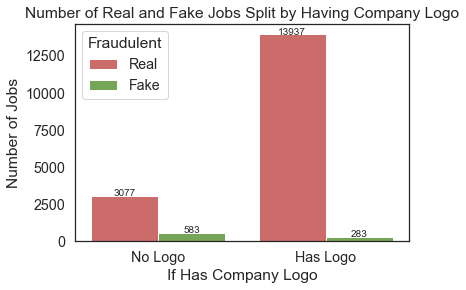

In [12]:
fig, axs = plt.subplots()
# fig.set_size_inches(20, 10)
graph = sns.countplot(x="has_company_logo",hue='fraudulent',palette=('#db5c5a', '#71b34b'), data=jobs)
plt.title('Number of Real and Fake Jobs Split by Having Company Logo')
graph.set(ylabel='Number of Jobs')
graph.set_xticklabels(['No Logo', 'Has Logo'])

graph.set_xlabel("If Has Company Logo")
graph.set_ylabel("Number of Jobs")
# graph.tick_params(labelsize=15)
graph.legend(title='Fraudulent', labels=['Real', 'Fake'])

for p in graph.patches:
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height + 2.5,height ,ha="center",size=10)

If the company has a logo, the number of real jobs are almost 50 times of the number of fake jobs. However, if the company doesn't ahve a logo, the number of real jobs are only about 5 times of the number of fake jobs. 

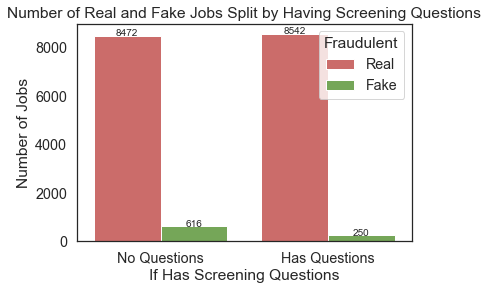

In [13]:
fig, axs = plt.subplots()
# fig.set_size_inches(20, 10)
graph = sns.countplot(x="has_questions",hue='fraudulent',palette=('#db5c5a', '#71b34b'), data=jobs)
plt.title('Number of Real and Fake Jobs Split by Having Screening Questions')
graph.set(ylabel='Number of Jobs')
graph.set_xticklabels(['No Questions', 'Has Questions'])

graph.set_xlabel("If Has Screening Questions")
graph.set_ylabel("Number of Jobs")
# graph.tick_params(labelsize=15)
graph.legend(title='Fraudulent', labels=['Real', 'Fake'])

for p in graph.patches:
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height + 2.5,height ,ha="center",size=10)

If the company provides screening questions, the number of real jobs are more t 34 times of the number of fake jobs.
If the compnay doesn't provide screening questions, the number of real jobs are only about 14 times of the number of fake jobs.

In [14]:
real_job = jobs[jobs.fraudulent == 0]
fake_job = jobs[jobs.fraudulent == 1]

In [15]:
stats.ttest_ind(real_job['telecommuting'],fake_job['telecommuting'])

Ttest_indResult(statistic=-4.6187600698561635, pvalue=3.887302945587036e-06)

In [16]:
stats.ttest_ind(real_job['has_company_logo'],fake_job['has_company_logo'])

Ttest_indResult(statistic=36.29542564584301, pvalue=2.213969660734465e-278)

In [17]:
stats.ttest_ind(real_job['has_questions'],fake_job['has_questions'])

Ttest_indResult(statistic=12.303110669974371, pvalue=1.203554661002495e-34)

Since the p-value for telecommuting, has_company_logo, and has_questions are really small (<0.05), there is almost no likelihood to have the difference by change, which means there is significant difference between real and fake jobs on if the company is telecommuting, if the company has a logo, and if the company has screening questions.

In [18]:
boo_fraud = pd.crosstab([jobs.telecommuting, jobs.has_company_logo, jobs.has_questions], 
                        jobs.fraudulent, margins = False)
boo_fraud

fraudulent                                       0    1
telecommuting has_company_logo has_questions           
0             0                0              2127  454
                               1               807   86
              1                0              6044  110
                               1              7333  152
1             0                0                87   36
                               1                56    7
              1                0               214   16
                               1               346    5

From the above contingency table, we can see that the most likely combination of being a fake job is the company is not telecommuting, has no logo and no screening questions.

## Question2: What's the most possible job title for fake jobs?

In [19]:
jobs.sample(5)

,title,description,benefits,telecommuting,has_company_logo,has_questions,fraudulent
12465,Digital Project Manager,We are looking for an experienced Digital Proj...,Salary (DOE)Benefits401k ABOUT DRAKE COOPERSin...,0,1,1,0
10088,Service Delivery Manager 1,The Service Delivery Manager will be based in ...,NaN,0,1,0,0
16465,Sales Manager,This is a fantastic opportunity to be part of ...,NaN,0,1,0,0
15192,Embedded and Application Engineer (communicati...,Do you enjoy working with bleeding edge techno...,"We are in an exciting growth phase, if you wou...",0,1,1,0
10462,English Teacher Abroad,"Play with kids, get paid for it Love travel? J...",See job description,0,1,1,0


In [20]:
title = ' '.join(fake_job['title'].values)
# title_tokens = clean_tokens(tokenize_str(clean_string(title)))
# text2 = ' '.join(title_tokens)

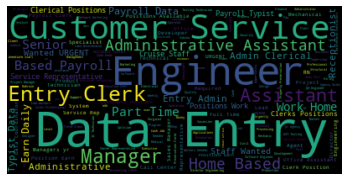

In [21]:
from wordcloud import WordCloud
# Generate a word cloud image
wordcloud2 = WordCloud().generate(title)

# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis("off")
plt.show()

## Question3: What's the most words said in the description and benefit?

In [22]:
import re
import nltk
from nltk.corpus import stopwords

In [23]:
def clean_string(string):
    string = string.lower().replace('\n', ' ')
    string = string.replace('\t', ' ')
    string = re.sub('&amp;', ' ',string)
    # should not sub . or , between the numbers
    string = re.sub('\W', ' ', string)
#     string = re.sub('[0-9]', ' ', string)
    return string

In [24]:
def tokenize_str(statement):
    tokens = nltk.word_tokenize(statement)
    return tokens

In [25]:
S = set(stopwords.words('english'))

def clean_tokens(tokens):
    cleaned_tokens = []
    for token in tokens:
        if token.lower() in S:
            pass
        else:
            cleaned_tokens.append(token)
            
    return cleaned_tokens

In [26]:
fake_job[fake_job['description'].isnull()]

,title,description,benefits,telecommuting,has_company_logo,has_questions,fraudulent
17513,Office Manager,NaN,NaN,0,0,0,1


In [27]:
fake_job.dropna(subset=['description'])

,title,description,benefits,telecommuting,has_company_logo,has_questions,fraudulent
98,IC&E Technician,"IC&amp;E Technician | Bakersfield, CA Mt. Poso...",BENEFITSWhat is offered:Competitive compensati...,0,1,1,1
144,Forward Cap.,The group has raised a fund for the purchase o...,NaN,0,0,0,1
173,Technician Instrument & Controls,Technician Instrument &amp; ControlsLocation D...,"we are a team of almost 8,000 employees who he...",0,1,1,1
180,Sales Executive,Sales Executive,Sales Executive,0,0,0,1
215,IC&E Technician Mt Poso,"IC&amp;E Technician | Bakersfield, CA Mt. Poso...",BENEFITSWhat is offered:Competitive compensati...,0,1,1,1
...,...,...,...,...,...,...,...
17827,Student Positions Part-Time and Full-Time.,Student Positions Part-Time and Full-Time.You ...,NaN,0,0,0,1
17828,Sales Associate,LEARN TO EARN AN EXECUTIVE LEVEL INCOMEFULL TR...,Who We Are We are a Global Leadership Developm...,0,0,1,1
17829,Android Developer,inFullMobile Sp. z o.o. is a mobile software d...,attractive salary (adequate to the candidate s...,0,0,0,1
17830,Payroll Clerk,JOB DESCRIPTIONWe are seeking a full time payr...,We offer a competitive salary and benefits pac...,0,0,0,1


In [28]:
fake_job['description'] = fake_job['description'].astype('str')

In [29]:
desc_fake = ' '.join(fake_job['description'].values)

In [30]:
desc_fake_tokens = clean_tokens(tokenize_str(clean_string(desc_fake)))

In [31]:
from collections import Counter
Counter(desc_fake_tokens).most_common(10)

[('work', 1052),
 ('team', 522),
 ('experience', 496),
 ('company', 491),
 ('time', 489),
 ('position', 477),
 ('management', 464),
 ('project', 454),
 ('customer', 453),
 ('service', 449)]

In [32]:
real_job[real_job['description'].isnull()]

,title,description,benefits,telecommuting,has_company_logo,has_questions,fraudulent


In [33]:
real_job['description'] = real_job['description'].astype('str')

In [34]:
desc_real = ' '.join(real_job['description'].values)

In [35]:
desc_real_tokens = clean_tokens(tokenize_str(clean_string(desc_real)))

In [36]:
Counter(desc_real_tokens).most_common(10)

[('team', 18257),
 ('work', 14422),
 ('business', 10474),
 ('experience', 9956),
 ('company', 9706),
 ('new', 9451),
 ('customer', 9428),
 ('sales', 9327),
 ('looking', 8346),
 ('development', 7967)]

In [37]:
fake_job[fake_job['benefits'].isnull()]

,title,description,benefits,telecommuting,has_company_logo,has_questions,fraudulent
144,Forward Cap.,The group has raised a fund for the purchase o...,NaN,0,0,0,1
493,Admin Assistant/ Receptionist,"A Newly established company seeks outgoing, fr...",NaN,0,0,0,1
537,Technology Consultant - Outside Sales,Apply below using link#URL_00962c0bdac3ecf40b2...,NaN,0,0,0,1
584,Quality Improvement Manager,Apply using below link#URL_8b28dea5804b323e29d...,NaN,0,0,0,1
606,Director of Strategy,"Director of Strategy | San Mateo, CA Intereste...",NaN,0,1,1,1
...,...,...,...,...,...,...,...
17822,5 Guys,Analyze the excel books of the franchise and t...,NaN,0,0,0,1
17824,Military Benefits Counselor,FOR MILITARY ONLYIf you can call present and p...,NaN,1,1,1,1
17826,Customer Service/Accounting Clerk,Cigna Inc is a prolific company seeking a self...,NaN,0,0,0,1
17827,Student Positions Part-Time and Full-Time.,Student Positions Part-Time and Full-Time.You ...,NaN,0,0,0,1


In [38]:
fake_job[fake_job['benefits'].notnull()]

,title,description,benefits,telecommuting,has_company_logo,has_questions,fraudulent
98,IC&E Technician,"IC&amp;E Technician | Bakersfield, CA Mt. Poso...",BENEFITSWhat is offered:Competitive compensati...,0,1,1,1
173,Technician Instrument & Controls,Technician Instrument &amp; ControlsLocation D...,"we are a team of almost 8,000 employees who he...",0,1,1,1
180,Sales Executive,Sales Executive,Sales Executive,0,0,0,1
215,IC&E Technician Mt Poso,"IC&amp;E Technician | Bakersfield, CA Mt. Poso...",BENEFITSWhat is offered:Competitive compensati...,0,1,1,1
357,Financing Auto(car) sales,If you have experience in financing for auto s...,profit sharingcar allowancecompany car,0,0,0,1
...,...,...,...,...,...,...,...
17823,Sales Person Required,Could this be the most rewarding opportunity a...,"What's on offer:Realistic OTE of £30,000 (unca...",0,0,0,1
17825,ADMINISTRATIVE & OFFICE ASSISTANT,ADMINISTRATIVE &amp; OFFICE ASSISTANTJOB DESCR...,You would be eligible to Benefits after 1 mont...,0,0,0,1
17828,Sales Associate,LEARN TO EARN AN EXECUTIVE LEVEL INCOMEFULL TR...,Who We Are We are a Global Leadership Developm...,0,0,1,1
17829,Android Developer,inFullMobile Sp. z o.o. is a mobile software d...,attractive salary (adequate to the candidate s...,0,0,0,1


In [39]:
fake_job['benefits'] = fake_job['benefits'].astype('str')

In [40]:
ben_fake = ' '.join(fake_job['benefits'].values)

In [41]:
ben_fake_tokens = clean_tokens(tokenize_str(clean_string(ben_fake)))

In [42]:
Counter(ben_fake_tokens).most_common(10)

[('nan', 364),
 ('benefits', 294),
 ('company', 217),
 ('work', 205),
 ('time', 161),
 ('paid', 149),
 ('training', 145),
 ('environment', 139),
 ('competitive', 130),
 ('full', 129)]

In [43]:
real_job[real_job['benefits'].isnull()]

,title,description,benefits,telecommuting,has_company_logo,has_questions,fraudulent
0,Marketing Intern,"Food52, a fast-growing, James Beard Award-winn...",NaN,0,1,0,0
2,Commissioning Machinery Assistant (CMA),"Our client, located in Houston, is actively se...",NaN,0,1,0,0
5,Accounting Clerk,Job OverviewApex is an environmental consultin...,NaN,0,0,0,0
8,HP BSM SME,Implementation/Configuration/Testing/Training ...,NaN,0,1,1,0
9,Customer Service Associate - Part Time,The Customer Service Associate will be based i...,NaN,0,1,0,0
...,...,...,...,...,...,...,...
17871,Water Truck Driver,Requires skilled work in operating commercial ...,NaN,0,1,1,0
17873,Recruiting Coordinator,RESPONSIBILITIES:Will facilitate the recruitin...,NaN,0,1,0,0
17874,JavaScript Developer,"Sr, JavaScript Developer Experience : 4-10 yea...",NaN,0,0,0,0
17877,Project Cost Control Staff Engineer - Cost Con...,Experienced Project Cost Control Staff Enginee...,NaN,0,0,0,0


In [44]:
real_job[real_job['benefits'].notnull()]

,title,description,benefits,telecommuting,has_company_logo,has_questions,fraudulent
1,Customer Service - Cloud Video Production,Organised - Focused - Vibrant - Awesome!Do you...,What you will get from usThrough being part of...,0,1,0,0
3,Account Executive - Washington DC,THE COMPANY: ESRI – Environmental Systems Rese...,Our culture is anything but corporate—we have ...,0,1,0,0
4,Bill Review Manager,JOB TITLE: Itemization Review ManagerLOCATION:...,Full Benefits Offered,0,1,1,0
6,Head of Content (m/f),Your Responsibilities: Manage the English-spea...,Your Benefits: Being part of a fast-growing co...,0,1,1,0
7,Lead Guest Service Specialist,Who is Airenvy?Hey there! We are seasoned entr...,Competitive Pay. You'll be able to eat steak e...,0,1,1,0
...,...,...,...,...,...,...,...
17867,Admin Assistant,We are seeking an administrator to work in a b...,"Salary £18,000Commission available after quali...",0,1,0,0
17872,Product Manager,Flite's SaaS display ad platform fuels the wor...,Competitive baseAttractive stock option planMe...,0,1,0,0
17875,Account Director - Distribution,Just in case this is the first time you’ve vis...,What can you expect from us?We have an open cu...,0,1,1,0
17876,Payroll Accountant,The Payroll Accountant will focus primarily on...,Health &amp; WellnessMedical planPrescription ...,0,1,1,0


In [45]:
real_job['benefits'] = real_job['benefits'].astype('str')

In [46]:
ben_real = ' '.join(real_job['benefits'].values)

In [47]:
ben_real_tokens = clean_tokens(tokenize_str(clean_string(ben_real)))

In [48]:
Counter(ben_real_tokens).most_common(10)

[('nan', 6846),
 ('work', 4262),
 ('benefits', 3577),
 ('company', 3239),
 ('competitive', 2911),
 ('team', 2644),
 ('salary', 2408),
 ('time', 2335),
 ('paid', 2249),
 ('dental', 1905)]

## Question4: How can I predict whether a job posting is fraudulent or not?

In [49]:
data = pd.get_dummies(jobs, prefix_sep='--')
data.sample(5)

,telecommuting,has_company_logo,has_questions,fraudulent,title-- Electrician,title-- Environmental Technician I,title-- Piping Material Engineer,"title-- Discipline Manager Civil, Structural, Marine, Architectural",title-- FEA Senior engineer,title-- Manager of Project Management Organization - Engineering,...,benefits--•Competitive Salary•Paid Time off•401 (K)•Healthcare,"benefits--• Salary: negotiate based on candidate's capabilities• Working time: 9:00AM ~ 18:00PM, 5 days a week (Monday to Friday)• Social Assurance base on Vietnam Labor Law.• Annual company summer holiday trips• Be trained to improve your skills in your expertise areas• Join a young and dynamic team in a friendly and professional working environment","benefits--• Competitive salary• Competitive equity grant in a high-growth startup• Beautiful office in downtown Austin, TX• Competively priced street parking ;)","benefits--• Work as a paid intern in an exciting new start-up• Be a part of taking a fast paced start-up to the next level• Lots of learning and networking, and playing an instrumental role in allowing us to expand our services to new markets• Potential inputs and involvement in other parts of the business",benefits--• Work as a paid intern in an exciting new start-up• Be a part of taking a fast paced start-up to the next level• Lots of learning and networking• Potential inputs and involvement in other parts of the business• Develop your own marketing ideas and implement them,"benefits--● .1% stock option● Excellent health benefit plan● 3 weeks paid time off per year, plus unlimited unpaid time off● 1 day paid employee volunteerism per month● Flexible hours● Travel opportunities● Room for growth, including leading your own team● Fun and easy-going environment","benefits--● Flexible Scheduling (Full and PT positions)● Competitive wages● Performance reviews &amp; incentives● On the job training &amp; caregiver support● Effective ""Zone Scheduling"" (to decrease mileage &amp; travel times)","benefits--● .1% stock option● 100% employer contributed health benefit plan● Flexible Paid Time Off (Unlimited)● 1 day paid employee volunteerism per month● Flexible hours● Travel opportunities● Room for growth, including leading your own team● Fun and easy-going environment","benefits--● .1% stock option● Excellent health benefit plan● 3 weeks paid time off per year, plus unlimited unpaid time off● 1 day paid employee volunteerism per month● Flexible hours● Travel opportunities● Room for growth, including leading your own team● Fun and easy-going environment",benefits-- The opportunity to move up rapidly within a fast-growing organisation Client contact and travel opportunities Personalised education and training plan to enhance marketing and wine knowledge Full immersion in the global wine industry Contributory company pension scheme No dull moments
11591,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9060,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8323,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13484,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11304,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [50]:
# Add your code for data splitting (train_test_split)
X = data.loc[:, data.columns != 'fraudulent']
y = data.loc[:, data.columns == 'fraudulent']

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns

In [52]:
rf_model = skens.RandomForestClassifier(n_estimators=100, oob_score=True, criterion='entropy')
rf_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

In [53]:
# this is testing the model 
predicted_labels = rf_model.predict(X_test)
X_test['predicted_rf_tree'] = predicted_labels

In [54]:
accuracy = accuracy_score(y_test, predicted_labels)
accuracy

0.970730797912006

In [55]:
# Check feature importance
feat_importance = rf_model.feature_importances_
feat_importance

array([1.87626278e-03, 6.69948771e-02, 8.89578888e-03, ...,
       1.54427626e-04, 5.53940803e-08, 0.00000000e+00])

In [56]:
# View our feature importances
feature_importance_zip = zip(list(X), rf_model.feature_importances_)

# Sort the feature_importance_zip
sorted_importance = sorted(feature_importance_zip, key=lambda x: x[1], reverse=True)

for feature in sorted_importance[:10]:
    print(feature)

('has_company_logo', 0.06699487713911845)
('description--We are seeking individuals to be connected with companies who are hiring employees directly to work from their homes. You will find both full-time and part-time opportunities in a variety of career fields including but not limited to: data entry, customer support, billing, typing, and administrative.These positions guarantee wages ranging from $12 per hour up to six figure salary. This includes bonuses, benefits, and flexibility over your work schedule.Legitimate work from home jobs are going to require that you have skills relevant to the position you’re applying for. Training is provided based on the position.', 0.011135852584591426)
('has_questions', 0.008895788875450674)
('title--Home Based Payroll Typist/Data Entry Clerks Positions Available', 0.008614938200923936)
('benefits--We offer• Friendly colleagues in an industry with a bright future.• An environment where you are encouraged to develop your skills and share your know

In [57]:
# Look at our feature importances without the dummy variables 
original_feature_dict = {}
for feature, importance in zip(list(X), rf_model.feature_importances_):
    # Check for our dummy variable delimeter --
    if '--' in feature:
        original_feature_name = feature.split('--')[0]
    else:
        original_feature_name = feature
        
    # Add to our original_feature_dict, incrememnt if it's already there
    if original_feature_name in original_feature_dict:
        original_feature_dict[original_feature_name] += importance
    else:
        original_feature_dict[original_feature_name] = importance

# Sort the original_feature_dict
sorted_importance = sorted(original_feature_dict.items(), key=lambda x: x[1], reverse=True)

for feature, importance in sorted_importance:
    print(feature, importance)

description 0.3733446412914578
title 0.35603706631720566
benefits 0.19285136360132854
has_company_logo 0.06699487713911845
has_questions 0.008895788875450674
telecommuting 0.0018762627754402208


In [ ]:
# # k-fold = 5
# param_grid = {
#                  'n_estimators': [10, 50, 100, 200, 250],
#                  'max_depth': [10, 30, 50],
#              }

# grid_clf = GridSearchCV(rf_model, param_grid, cv=5, scoring='accuracy')
# grid_clf.fit(X_train,y_train)

In [ ]:
# grid_clf.best_params_

In [ ]:
# grid_clf.best_score_

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [60]:
# train the NB model
gnb_model = sknb.GaussianNB()
# given sepal length, predict if setosa
gnb_model.fit(X_train,y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [61]:
# test the model
y_pred = gnb_model.predict(X_test)
X_test['predicted_nb'] = y_pred

In [62]:
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.5715883668903803

In [63]:
# BernoulliNB 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

bnb_model = sknb.BernoulliNB()
bnb_model.fit(X_train, y_train)

y_pred = bnb_model.predict(X_test)
# X_test['predicted_nb'] = y_pred

accuracy = accuracy_score(y_test, y_pred)
accuracy

0.9576808351976137